<a href="https://colab.research.google.com/github/gusujio/neural_networks_start/blob/master/%D1%81%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
import torch

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets

In [6]:

CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [7]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [8]:
len(y_train), len(y_test)

(50000, 10000)

In [9]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

теперь значения будут от 0 1

In [10]:
X_train /= 255.
X_test /= 255.

In [11]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

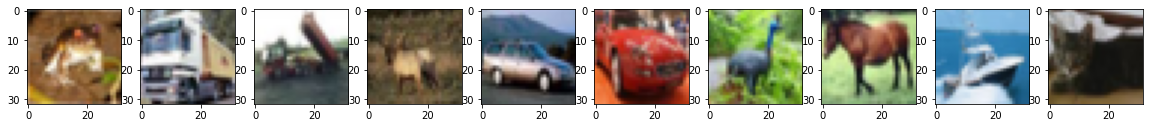

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

In [13]:
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

Ещё одна особенность этого датасета: как и у обычных картинок, канал "цвет" кодируется в последней размерности. То есть, сначала идёт высота картинки, ширина, а после этого уже цвет. Но pytorch требует, чтобы этот канал шёл на первом месте. То есть, мы имеем сейчас 4-мерный тензор: "количество картинок, высота, ширина и цвет", а Pytorch хочет: "количество картинок, количество цветов, ширина, высота". И теперь нам нужно реорганизовать размерность нашего тензора таким образом, чтобы цвет шёл на втором месте -- как раз после количества картинок в датасете. Это делается с помощью метода "permute". Вот здесь у нас permute с четырьмя аргументами. Первый аргумент "0" отвечает за количество картинок в нашем датасете. Мы не хотим, чтобы "количество картинок" в датасете поменяло позицию, соответственно тут стоит ноль. Далее стоит число "3" -- это значит, что на это место придёт размерность, которая была под номером "3" в изначальном тензоре, то есть это будет "количество каналов". 

In [14]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [15]:
X_train.shape

torch.Size([50000, 3, 32, 32])

Далее -- мы изменим нашу сеть LeNet таким образом, чтобы она принимала изображения 32 на 32 и три канала на входе. Чтобы передать ей три канала, нужно в in_chanels первой же конволюции поставить "3" (раньше у нас тут было "1"). А вот размерность 32 на 32 у нас получается из паддинга.

In [16]:
class LeNet5(torch.nn.Module):
    def __init__(self,
                 activation='tanh',
                 pooling='avg',
                 conv_size=5, 
                 use_batch_norm=False):
        super(LeNet5, self).__init__()
        
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        else:
            raise NotImplementedError
            
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError
        
        if conv_size == 5:
            self.conv1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv1_1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=3, padding=0)
            self.conv1_2 = torch.nn.Conv2d(
                in_channels=6, out_channels=6, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling_layer
       
        if conv_size == 5:
            self.conv2 = self.conv2 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = activation_function
    
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function
        
        self.fc3 = torch.nn.Linear(84, 10)
        
    def forward(self, x):
        if self.conv_size == 5:
            x = self.conv1(x)
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))
        x = self.act1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)
        
        if self.conv_size == 5:
            x = self.conv2(x)
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))
        x = self.act2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x                

In [20]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    
    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(30):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            
            X_batch

        net.eval()
        test_preds = net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)

        print(accuracy)
    del net
    return test_accuracy_history, test_loss_history

accuracies = {}
losses = {}

accuracies['tanh'], losses['tanh'] = \
    train(LeNet5(activation='tanh', conv_size=5),
          X_train, y_train, X_test, y_test)
accuracies['relu'], losses['relu'] = \
    train(LeNet5(activation='relu', conv_size=5),
          X_train, y_train, X_test, y_test)
accuracies['relu_3'], losses['relu_3'] = \
    train(LeNet5(activation='relu', conv_size=3),
          X_train, y_train, X_test, y_test)
accuracies['relu_3_max_pool'], losses['relu_3_max_pool'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max'), 
          X_train, y_train, X_test, y_test)
accuracies['relu_3_max_pool_bn'], losses['relu_3_max_pool_bn'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max', use_batch_norm=True), 
          X_train, y_train, X_test, y_test)            

tensor(0.3898)
tensor(0.4458)
tensor(0.4812)
tensor(0.5090)


KeyboardInterrupt: ignored

Давайте посмотрим на результаты.  LeNet, изначальный он обучается примерно на 55% accuracy, то есть он угадывает в 55% процентах случаев. Напомню, что классов 10, поэтому это не самое плохое качество. Если бы он угадывал случайно, то, наверное, было бы качество "0.1". На втором месте идут LeNet, в которых мы изменили активации -- сделали там активации ReLU. Это дало целых 5% качества. Кроме того, мы видим, что -- используем мы ReLU с 3 на 3 или 5 на 5 -- нет никакой разницы (зелёная линия -- это 5 на 5, красная -- это две свёртки 3 на 3). Кроме того, мы видим, что max pooling добавляет нам ещё целых 5% качества. То есть max pooling, по сравнению с average pooling, на данной задаче получает очень большой boost в качестве. И, в принципе, на любой задаче связанной с изображениями у вас будет так же. И, кроме того, мы видим интересную особенность батч-нормализации: сетка с батч-нормализацией учится очень быстро. Тот эффект, который мы и хотели от батч-нормализации -- ускорение обучения. Мы видим, что уже на пятой эпохе сетка достигает качества, которое без батч-нормализации достигается на 20-й эпохе. То есть, у нас получается ускорение в четыре раза. Но, кроме того, мы видим также, что батч-нормализация и переобучается быстрее. Логично предположить, что если весь процесс обучения ускоряется, то и момент переобучения наступает быстрее 

No handles with labels found to put in legend.


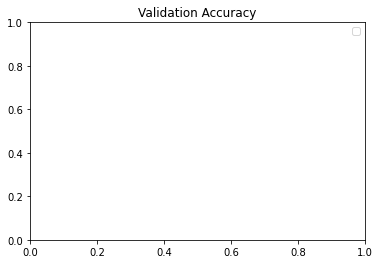

In [21]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

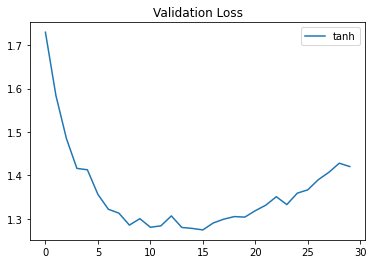

In [19]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');

Давайте добавим фильтров и посмотрим -- а если мы из изображения будем извлекать больше информации, может быть, и качество станет лучше. Возьмём все идеи из предыдущего шага и поместим их в одну лаконичную сеть -- назовём её "CIFARNet".

Кроме того, наши конволюции будут выходить за размер изображения, чтобы этот размер не менялся до и после конволюции. В принципе, зачастую, это хорошая идея, потому что таким образом сеть понимает -- а где границы изображения, в каком месте конволюция находятся в данный момент, находится она в углу изображения, слева или справа. Дополнительная информация, которая раньше не была доступна.

In [ ]:
class CIFARNet(torch.nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()
# Сперва мы применим батч-нормализацию к исходному изображению 
# -- в принципе, такую батч-нормализацию можно трактовать
#  как нормировку по яркости и контрасту изначального изображения.        
        self.batch_norm0 = torch.nn.BatchNorm2d(3)
#кол-во каналов на вход, а потом на выход и размер свертки, pad для сохр-яя размерности
        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1) 
        self.act1  = torch.nn.ReLU() #активация ReLU
        self.batch_norm1 = torch.nn.BatchNorm2d(16) #батч-нормализация
        self.pool1 = torch.nn.MaxPool2d(2, 2) #max pooling
        
        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.act2  = torch.nn.ReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        
        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.act3  = torch.nn.ReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(64)
# растягиваем в один тензор 
# 8 на 8 обусловлено размером тензора, который пришёл после последней свёртки
        self.fc1   = torch.nn.Linear(8 * 8 * 64, 256)
        self.act4  = torch.nn.Tanh()
        self.batch_norm4 = torch.nn.BatchNorm1d(256)
        
        self.fc2   = torch.nn.Linear(256, 64)
        self.act5  = torch.nn.Tanh()
        self.batch_norm5 = torch.nn.BatchNorm1d(64)
        
        self.fc3   = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm3(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.batch_norm5(x)
        x = self.fc3(x)
        
        return x        

In [ ]:

accuracies['cifar_net'], losses['cifar_net'] = \
    train(CIFARNet(), X_train, y_train, X_test, y_test)

На графике validation accuracy мы видим, что наша новая сеть, которую мы назвали CIFARNet, побеждает все предыдущие реализации. И, видимо, это происходит из-за того, что у неё больше фильтров в конволюциях. Давайте посмотрим ещё графики лоссов, и на этом графике видно, что после 3-й эпохи обучать сеть уже бессмысленно, она не улучшается по качеству, но её уверенности становятся более категоричными. То есть сеть становится более уверена даже в своих неправильных предсказаниях, из-за чего график лосса сильно растёт.

In [ ]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

In [ ]:

for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');

Резюмируя: на этом семинаре мы научились работать с конволюционными нейронными сетями. Мы получили некоторую интуицию, как влияют на сеть разные функции активации, разные пулинги, что будет, если добавить в нейронную сеть батч-нормализации, как влияют различные свёртки. Мы видим, что в разных датасетах, в разных задачах, возможно, подходят разные свёртки. И мы увидели на практике, что такое переобучение, почему необязательно сеть нужно обучать бесконечно долго, почему нужно останавливаться. В принципе, мы могли бы сюда добавить ещё такие слои как DropOut, мы могли бы добавить сюда регуляризацию, и посмотреть, а как влияет это всё на обучение сети.